# An Introduction to the Amazon SageMaker IP Insights Algorithm
#### Unsupervised anomaly detection for susicipous IP addresses
-------
1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Training](#Training)
4. [Inference](#Inference)
5. [Epilogue](#Epilogue)

## Introduction
-------

The Amazon SageMaker IP Insights algorithm uses statistical modeling and neural networks to capture associations between online resources (such as account IDs or hostnames) and IPv4 addresses. Under the hood, it learns vector representations for online resources and IP addresses. This essentially means that if the vector representing an IP address and an online resource are close together, then it is likey for that IP address to access that online resource, even if it has never accessed it before.

In this notebook, we use the Amazon SageMaker IP Insights algorithm to train a model on synthetic data. We then use this model to perform inference on the data and show how to discover anomalies. After running this notebook, you should be able to:

- obtain, transform, and store data for use in Amazon SageMaker,
- create an AWS SageMaker training job to produce an IP Insights model,
- use the model to perform inference with an Amazon SageMaker endpoint.

If you would like to know more, please check out the [SageMaker IP Inisghts Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ip-insights.html). 

## Setup
------
*This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts.

### 1. Select Amazon S3 Bucket
We first need to specify the locations where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

- `bucket` - An S3 bucket accessible by this account.
- `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)

**Note: Please ensure that the following pre-requisite are set-up. For Instruction, please check with your instructor** 
1. Create IAM Role
2. Create S3 Bucket
3. Create SageMaker Notebook Instance

**Step 1.1: Verify that Execution Role is set.**

In [33]:
# Set Variable Used below
# Set S3 Bucket Name
bucket = "aseansecaiml-25apr2023"

# Set Execution Role
from sagemaker import get_execution_role

role = get_execution_role()
print(f"Execution role set: {role}")

Execution role set: arn:aws:iam::817562650497:role/service-role/SageMaker-DataScientist


**Step 1.2: Verified that S3 Bucket is set** 

In [34]:
import boto3
import botocore
import os
import sagemaker


#bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/ipinsights-tutorial"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# check if the bucket exists
try:
    boto3.Session().client("s3").head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print(
        "Hey! You either forgot to specify your S3 bucket or you gave your bucket an invalid name!"
    )
except botocore.exceptions.ClientError as e:
    if e.response["Error"]["Code"] == "403":
        print(f"Hey! You don't have permission to access the bucket, {bucket}.")
    elif e.response["Error"]["Code"] == "404":
        print(f"Hey! Your bucket, {bucket}, doesn't exist!")
    else:
        raise
else:
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")

Training input/output will be stored in: s3://aseansecaiml-25apr2023/sagemaker/ipinsights-tutorial


**Step 1.3: Next we download the modules necessary for synthetic data generation they do not exist.**

> WARNING: If the Synethic data generation module do not exists, please get them from your instructor

In [53]:
from os import path

tools_bucket = f"jumpstart-cache-prod-{region}"  # Bucket containing the data generation module.
tools_prefix = "1p-algorithms-assets/ip-insights"  # Prefix for the data generation module

print(f"Tools Bucket set as: {tools_bucket}\n")
print(f"Tools Prefix set as: {tools_prefix}\n")

s3 = boto3.client("s3")

data_generation_file = "generate_data.py"  # Synthetic data generation module
script_parameters_file = "ip2asn-v4-u32.tsv.gz"

print(f" ### CHECKING IF DATA EXISTED ###")
if path.exists(data_generation_file) and path.exists(script_parameters_file):
    print(f"{data_generation_file} and {script_parameters_file} existed. You are good to go.")
else:
    print(f"WARNING: Please get the file from the instructer")

    
# if not path.exists(data_generation_file):
#     s3.download_file(tools_bucket, f"{tools_prefix}/{data_generation_file}", data_generation_file)
#     printf("downloading file")
# if not path.exists(script_parameters_file):
#     s3.download_file(
#         tools_bucket, f"{tools_prefix}/{script_parameters_file}", script_parameters_file
#     )
#     printf("downloading file")

Tools Bucket set as: jumpstart-cache-prod-ap-southeast-1

Tools Prefix set as: 1p-algorithms-assets/ip-insights

 ### CHECKING IF DATA EXISTED ###
generate_data.py and ip2asn-v4-u32.tsv.gz existed. You are good to go.


### 2. Dataset

Apache Web Server ("httpd") is the most popular web server used on the internet. And luckily for us, it logs all requests processed by the server - by default. If a web page requires HTTP authentication, the Apache Web Server will log the IP address and authenticated user name for each requested resource. 

The [access logs](https://httpd.apache.org/docs/2.4/logs.html) are typically on the server under the file `/var/log/httpd/access_log`. From the example log output below, we see which IP addresses each user has connected with:

```
192.168.1.100 - user1 [15/Oct/2018:18:58:32 +0000] "GET /login_success?userId=1 HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36"
192.168.1.102 - user2 [15/Oct/2018:18:58:35 +0000] "GET /login_success?userId=2 HTTP/1.1" 200 - "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36"
...
```

If we want to train an algorithm to detect suspicious activity, this dataset is ideal for SageMaker IP Insights.

First, we determine the resource we want to be analyzing (such as a login page or access to a protected file). Then, we construct a dataset containing the history of all past user interactions with the resource. We extract out each 'access event' from the log and store the corresponding user name and IP address in a headerless CSV file with two columns. The first column will contain the user identifier string, and the second will contain the IPv4 address in decimal-dot notation. 

```
user1, 192.168.1.100
user2, 193.168.1.102
...
```

As a side note, the dataset should include all access events. That means some `<user_name, ip_address>` pairs will be repeated. 

#### Step 2.1: User Activity Simulation
For this example, we are going to simulate our own web-traffic logs. We mock up a toy website example and simulate users logging into the website from mobile devices. 

The details of the simulation are explained in the script [here](./generate_data.py). 



In [2]:
from generate_data import generate_dataset

# We simulate traffic for 10,000 users. This should yield about 3 million log lines (~700 MB).
NUM_USERS = 10000
log_file = "ipinsights_web_traffic.log"
generate_dataset(NUM_USERS, log_file)

# Visualize a few log lines
!head $log_file

Loaded ASN List: 827696 ASNs.
Starting User Activity Simulation


100%|██████████| 10000/10000 [01:18<00:00, 126.76users/s]


Finished simulating web activity for 10000 users.
117.197.31.85 - user_63 [12/Nov/2018:03:04:20 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
117.196.121.229 - user_63 [12/Nov/2018:18:45:01 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
117.195.10.78 - user_63 [09/Nov/2018:05:48:21 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
117.195.115.0 - user_63 [09/Nov/2018:15:25:07 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
117.195.150.50 - user_63 [12/Nov/2018:11:07:16 +0000] "GET /login_succes

### 3. Prepare the dataset
Now that we have our logs, we need to transform them into a format that IP Insights can use. As we mentioned above, we need to:
1. Choose the resource which we want to analyze users' history for
2. Extract our users' usage history of IP addresses
3. In addition, we want to separate our dataset into a training and test set. This will allow us to check for overfitting by evaluating our model on 'unseen' login events.

For the rest of the notebook, we assume that the Apache Access Logs are in the Common Log Format as defined by the [Apache documentation](https://httpd.apache.org/docs/2.4/logs.html#accesslog). We start with reading the logs into a Pandas DataFrame for easy data exploration and pre-processing.

**Step 3.1: Reading the log file**

In [3]:
import pandas as pd
print(f"Reading csv. Please wait...")
df = pd.read_csv(
    log_file,
    sep=" ",
    na_values="-",
    header=None,
    names=[
        "ip_address",
        "rcf_id",
        "user",
        "timestamp",
        "time_zone",
        "request",
        "status",
        "size",
        "referer",
        "user_agent",
    ],
)
df.head()

Reading csv. Please wait...


,ip_address,rcf_id,user,timestamp,time_zone,request,status,size,referer,user_agent
0,117.197.31.85,NaN,user_63,[12/Nov/2018:03:04:20,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
1,117.196.121.229,NaN,user_63,[12/Nov/2018:18:45:01,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
2,117.195.10.78,NaN,user_63,[09/Nov/2018:05:48:21,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
3,117.195.115.0,NaN,user_63,[09/Nov/2018:15:25:07,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
4,117.195.150.50,NaN,user_63,[12/Nov/2018:11:07:16,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...


**Step 3.2: We convert the log timestamp strings into Python datetimes so that we can sort and compare the data more easily.**

In [4]:
# Convert time stamps to DateTime objects
df["timestamp"] = pd.to_datetime(df["timestamp"], format="[%d/%b/%Y:%H:%M:%S")

In [5]:
# Compare the changed Timestamp with earlier
df.head()

,ip_address,rcf_id,user,timestamp,time_zone,request,status,size,referer,user_agent
0,117.197.31.85,NaN,user_63,2018-11-12 03:04:20,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
1,117.196.121.229,NaN,user_63,2018-11-12 18:45:01,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
2,117.195.10.78,NaN,user_63,2018-11-09 05:48:21,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
3,117.195.115.0,NaN,user_63,2018-11-09 15:25:07,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
4,117.195.150.50,NaN,user_63,2018-11-12 11:07:16,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...


In [17]:
# Total Unique Record
Total_Records = df.nunique()

print(f"Total Unique Record: {Total_Records}")

Total Unique Record: ip_address    2801329
rcf_id              0
user            10000
timestamp      842748
time_zone           1
request             1
status              1
size                1
referer             0
user_agent          1
dtype: int64


**Step 3.3: We also verify the time zones of all of the time stamps. If the log contains more than one time zone, we would need to standardize the timestamps.**

In [7]:
# Check if they are all in the same timezone
num_time_zones = len(df["time_zone"].unique())
num_time_zones

print(f"Num of Time Zone: {num_time_zones}")

Num of Time Zone: 1


As we see above, there is only one value in the entire `time_zone` column. Therefore, all of the timestamps are in the same time zone, and we do not need to standardize them. We can skip the next cell and go to [1. Selecting a Resource](#1.-Select-Resource).

If there is more than one time_zone in your dataset, then we parse the timezone offset and update the corresponding datetime object. 

**Note:** The next cell takes about 5-10 minutes to run.

In [8]:
from datetime import datetime
import pytz


def apply_timezone(row):
    tz = row[1]
    tz_offset = int(tz[:3]) * 60  # Hour offset
    tz_offset += int(tz[3:5])  # Minutes offset
    return row[0].replace(tzinfo=pytz.FixedOffset(tz_offset))


if num_time_zones > 1:
    print("f We will standardize the timezone since there are more than 1 timezone.")
    df["timestamp"] = df[["timestamp", "time_zone"]].apply(apply_timezone, axis=1)

### 4. Analyze Dataset

#### 4.1. Select Resource
Our goal is to train an IP Insights algorithm to analyze the history of user logins such that we can predict how suspicious a login event is. 

In our simulated web server, the server logs a `GET` request to the `/login_success` page everytime a user successfully logs in. We filter our Apache logs for `GET` requests for `/login_success`. We also filter for requests that have a `status_code == 200`, to ensure that the page request was well formed. 

**Note:** every web server handles logins differently. For your dataset, determine which resource you will need to be analyzing to correctly frame this problem. Depending on your usecase, you may need to do more data exploration and preprocessing.

In [18]:
df = df[(df["request"].str.startswith("GET /login_success")) & (df["status"] == 200)]

In [19]:
df.head()

,ip_address,rcf_id,user,timestamp,time_zone,request,status,size,referer,user_agent
0,117.197.31.85,NaN,user_63,2018-11-12 03:04:20,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
1,117.196.121.229,NaN,user_63,2018-11-12 18:45:01,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
2,117.195.10.78,NaN,user_63,2018-11-09 05:48:21,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
3,117.195.115.0,NaN,user_63,2018-11-09 15:25:07,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
4,117.195.150.50,NaN,user_63,2018-11-12 11:07:16,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...


#### 4.2. Extract Users and IP address
Now that our DataFrame only includes log events for the resource we want to analyze, we extract the relevant fields to construct a IP Insights dataset.

IP Insights takes in a headerless CSV file with two columns: an entity (username) ID string and the IPv4 address in decimal-dot notation. Fortunately, the Apache Web Server Access Logs output IP addresses and authenticated usernames in their own columns.

**Note:** Each website handles user authentication differently. If the Access Log does not output an authenticated user, you could explore the website's query strings or work with your website developers on another solution.

In [20]:
df = df[["user", "ip_address", "timestamp"]]
df.head()

,user,ip_address,timestamp
0,user_63,117.197.31.85,2018-11-12 03:04:20
1,user_63,117.196.121.229,2018-11-12 18:45:01
2,user_63,117.195.10.78,2018-11-09 05:48:21
3,user_63,117.195.115.0,2018-11-09 15:25:07
4,user_63,117.195.150.50,2018-11-12 11:07:16


#### 4.3. Create training and test dataset
As part of training a model, we want to evaluate how it generalizes to data it has never seen before.

Typically, you create a test set by reserving a random percentage of your dataset and evaluating the model after training. However, for machine learning models that make future predictions on historical data, we want to use out-of-time testing. Instead of randomly sampling our dataset, we split our dataset into two contiguous time windows. The first window is the training set, and the second is the test set. 

We first look at the time range of our dataset to select a date to use as the partition between the training and test set.

In [21]:
df["timestamp"].describe()

/tmp/ipykernel_5094/52595715.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df["timestamp"].describe()


count                 3198024
unique                 842748
top       2018-11-11 09:45:07
freq                       16
first     2018-11-04 00:00:01
last      2018-11-14 00:00:00
Name: timestamp, dtype: object

We have login events for 10 days. Let's take the first week (7 days) of data as training and then use the last 3 days for the test set.

In [22]:
time_partition = (
    datetime(2018, 11, 11, tzinfo=pytz.FixedOffset(0))
    if num_time_zones > 1
    else datetime(2018, 11, 11)
)

train_df = df[df["timestamp"] <= time_partition]
test_df = df[df["timestamp"] > time_partition]

In [26]:
#Compare Training and Test Data
print(f"Training Data")
train_df.head()

Training Data


,user,ip_address,timestamp
2,user_63,117.195.10.78,2018-11-09 05:48:21
3,user_63,117.195.115.0,2018-11-09 15:25:07
5,user_63,107.181.70.155,2018-11-10 14:06:39
7,user_63,107.181.133.213,2018-11-05 12:52:17
9,user_63,117.196.123.163,2018-11-07 23:50:27


In [27]:
print(f"Test Data")
test_df.head()

Test Data


,user,ip_address,timestamp
0,user_63,117.197.31.85,2018-11-12 03:04:20
1,user_63,117.196.121.229,2018-11-12 18:45:01
4,user_63,117.195.150.50,2018-11-12 11:07:16
6,user_63,107.181.81.80,2018-11-11 01:27:33
8,user_63,107.181.96.198,2018-11-12 06:26:05


Now that we have our training dataset, we shuffle it. 

Shuffling improves the model's performance since SageMaker IP Insights uses stochastic gradient descent. This ensures that login events for the same user are less likely to occur in the same mini batch. This allows the model to improve its performance in between predictions of the same user, which will improve training convergence.

In [28]:
# Shuffle train data
train_df = train_df.sample(frac=1)
train_df.head()

,user,ip_address,timestamp
241523,user_858,210.135.127.15,2018-11-06 08:55:20
28951,user_140,142.25.205.109,2018-11-09 00:45:05
857006,user_2766,214.2.17.106,2018-11-09 02:40:59
3040245,user_9433,107.150.26.114,2018-11-10 14:59:40
539604,user_1507,193.109.139.223,2018-11-05 06:31:31


### 5. Store Data on S3

Now that we have simulated (or scraped) our datasets, we have to prepare and upload it to S3.

We will be doing local inference, therefore we don't need to upload our test dataset.

In [29]:
# Output dataset as headerless CSV
train_data = train_df.to_csv(index=False, header=False, columns=["user", "ip_address"])

In [35]:
# Upload data to S3 key
train_data_file = "train.csv"
key = os.path.join(prefix, "train", train_data_file)
s3_train_data = f"s3://{bucket}/{key}"

print(f"Uploading data to: {s3_train_data}")
boto3.resource("s3").Bucket(bucket).Object(key).put(Body=train_data)

# Configure SageMaker IP Insights Input Channels
input_data = {
    "train": sagemaker.session.s3_input(
        s3_train_data, distribution="FullyReplicated", content_type="text/csv"
    )
}

Uploading data to: s3://aseansecaiml-25apr2023/sagemaker/ipinsights-tutorial/train/train.csv


The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [58]:
#List all the files in S3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket)

for my_bucket_object in my_bucket.objects.all():
    print(f"{my_bucket_object.key}\n")

sagemaker/ipinsights-tutorial/output/ipinsights-2023-04-26-09-29-54-391/profiler-output/system/incremental/2023042609/1682501460.algo-1.json

sagemaker/ipinsights-tutorial/output/ipinsights-2023-04-26-09-29-54-391/profiler-output/system/incremental/2023042609/1682501520.algo-1.json

sagemaker/ipinsights-tutorial/output/ipinsights-2023-04-26-09-29-54-391/profiler-output/system/incremental/2023042609/1682501580.algo-1.json

sagemaker/ipinsights-tutorial/output/ipinsights-2023-04-26-09-29-54-391/profiler-output/system/incremental/2023042609/1682501640.algo-1.json

sagemaker/ipinsights-tutorial/output/ipinsights-2023-04-26-09-29-54-391/profiler-output/system/incremental/2023042609/1682501700.algo-1.json

sagemaker/ipinsights-tutorial/output/ipinsights-2023-04-26-09-29-54-391/profiler-output/system/incremental/2023042609/1682501760.algo-1.json

sagemaker/ipinsights-tutorial/output/ipinsights-2023-04-26-09-29-54-391/profiler-output/system/incremental/2023042609/1682501820.algo-1.json

sagema

## Training
---
Once the data is preprocessed and available in the necessary format, the next step is to train our model on the data. There are number of parameters required by the SageMaker IP Insights algorithm to configure the model and define the computational environment in which training will take place. The first of these is to point to a container image which holds the algorithms training and hosting code:

### 1. Getting Prebuild SageMaker Docker Image

In [52]:
# This is deprecated to sagemaker.image_uris.retrieve
from sagemaker.amazon.amazon_estimator import image_uris

image = image_uris.retrieve(framework='ipinsights',region=boto3.Session().region_name)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Then, we need to determine the training cluster to use. The IP Insights algorithm supports both CPU and GPU training. We recommend using GPU machines as they will train faster. However, when the size of your dataset increases, it can become more economical to use multiple CPU machines running with distributed training. See [Recommended Instance Types](https://docs.aws.amazon.com/sagemaker/latest/dg/ip-insights.html#ip-insights-instances) for more details. 

### 2. Training
#### 2.1 Training Job Configuration
- **train_instance_type**: the instance type to train on. We recommend `p3.2xlarge` for single GPU, `p3.8xlarge` for multi-GPU, and `m5.2xlarge` if using distributed training with CPU;
- **train_instance_count**: the number of worker nodes in the training cluster.

We need to also configure SageMaker IP Insights-specific hypeparameters:

#### 2.2 Model Hyperparameters
- **num_entity_vectors**: the total number of embeddings to train. We use an internal hashing mechanism to map the entity ID strings to an embedding index; therefore, using an embedding size larger than the total number of possible values helps reduce the number of hash collisions. We recommend this value to be 2x the total number of unique entites (i.e. user names) in your dataset;
- **vector_dim**: the size of the entity and IP embedding vectors. The larger the value, the more information can be encoded using these representations but using too large vector representations may cause the model to overfit, especially for small training data sets;
- **num_ip_encoder_layers**: the number of layers in the IP encoder network. The larger the number of layers, the higher the model capacity to capture patterns among IP addresses. However, large number of layers increases the chance of overfitting. `num_ip_encoder_layers=1` is a good value to start experimenting with;
- **random_negative_sampling_rate**: the number of randomly generated negative samples to produce per 1 positive sample; `random_negative_sampling_rate=1` is a good value to start experimenting with;
    - Random negative samples are produced by drawing each octet from a uniform distributed of [0, 255];
- **shuffled_negative_sampling_rate**: the number of shuffled negative samples to produce per 1 positive sample; `shuffled_negative_sampling_rate=1` is a good value to start experimenting with;
    - Shuffled negative samples are produced by shuffling the accounts within a batch;

#### 2.3 Training Hyperparameters
- **epochs**: the number of epochs to train. Increase this value if you continue to see the accuracy and cross entropy improving over the last few epochs;
- **mini_batch_size**: how many examples in each mini_batch. A smaller number improves convergence with stochastic gradient descent. But a larger number is necessary if using shuffled_negative_sampling to avoid sampling a wrong account for a negative sample;
- **learning_rate**: the learning rate for the Adam optimizer (try ranges in [0.001, 0.1]). Too large learning rate may cause the model to diverge since the training would be likely to overshoot minima. On the other hand, too small learning rate slows down the convergence;
- **weight_decay**: L2 regularization coefficient. Regularization is required to prevent the model from overfitting the training data. Too large of a value will prevent the model from learning anything;

For more details, see [Amazon SageMaker IP Insights (Hyperparameters)](https://docs.aws.amazon.com/sagemaker/latest/dg/ip-insights-hyperparameters.html). Additionally, most of these hyperparameters can be found using SageMaker Automatic Model Tuning; see [Amazon SageMaker IP Insights (Model Tuning)](https://docs.aws.amazon.com/sagemaker/latest/dg/ip-insights-tuning.html) for more details. 

In [55]:
# Set up the estimator with training job configuration
ip_insights = sagemaker.estimator.Estimator(
    image,
    execution_role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=sagemaker.Session(),
)

# Configure algorithm-specific hyperparameters
ip_insights.set_hyperparameters(
    num_entity_vectors="20000",
    random_negative_sampling_rate="5",
    vector_dim="128",
    mini_batch_size="1000",
    epochs="5",
    learning_rate="0.01",
)

# Start the training job (should take about ~1.5 minute / epoch to complete)
ip_insights.fit(input_data)

INFO:sagemaker:Creating training-job with name: ipinsights-2023-04-26-09-29-54-391


2023-04-26 09:29:54 Starting - Starting the training job...
2023-04-26 09:30:18 Starting - Preparing the instances for training......
2023-04-26 09:31:19 Downloading - Downloading input data...
2023-04-26 09:31:39 Training - Downloading the training image............
2023-04-26 09:33:45 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Wed Apr 26 09:34:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                     

ClientError: An error occurred (AccessDeniedException) when calling the DescribeTrainingJob operation: User: arn:aws:sts::817562650497:assumed-role/SageMaker-DataScientist/SageMaker is not authorized to perform: sagemaker:DescribeTrainingJob on resource: arn:aws:sagemaker:ap-southeast-1:817562650497:training-job/ipinsights-2023-04-26-09-29-54-391 because no identity-based policy allows the sagemaker:DescribeTrainingJob action

If you see the message

    > Completed - Training job completed

at the bottom of the output logs then that means training successfully completed and the output of the SageMaker IP Insights model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [56]:
print(f"Training job name: {ip_insights.latest_training_job.job_name}")

Training job name: ipinsights-2023-04-26-09-29-54-391


## 3 Inference
-----

Now that we have trained a SageMaker IP Insights model, we can deploy the model to an endpoint to start performing inference on data. In this case, that means providing it a `<user, IP address>` pair and predicting their compatability scores.

We can create an inference endpoint using the SageMaker Python SDK `deploy()`function from the job we defined above. We specify the instance type where inference will be performed, as well as the initial number of instnaces to spin up. We recommend using the `ml.m5` instance as it provides the most memory at the lowest cost. Verify how large your model is in S3 and pick the instance type with the appropriate amount of memory.

### 1. Creating Inference Endpoint

In [60]:
predictor = ip_insights.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

INFO:sagemaker:Creating model with name: ipinsights-2023-04-26-09-55-52-731
INFO:sagemaker:Creating endpoint-config with name ipinsights-2023-04-26-09-55-52-731
INFO:sagemaker:Creating endpoint with name ipinsights-2023-04-26-09-55-52-731


-------!

Congratulations, you now have a SageMaker IP Insights inference endpoint! You could start integrating this endpoint with your production services to start querying incoming requests for abnormal behavior. 

You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name below:

In [61]:
print(f"Endpoint name: {predictor.endpoint}")

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: ipinsights-2023-04-26-09-55-52-731


### 2. Data Serialization/Deserialization
We can pass data in a variety of formats to our inference endpoint. In this example, we will pass CSV-formmated data. Other available formats are JSON-formated and JSON Lines-formatted. We make use of the SageMaker Python SDK utilities: `csv_serializer` and `json_deserializer` when configuring the inference endpoint

In [62]:
from sagemaker.predictor import csv_serializer, json_deserializer

predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer

Now that the predictor is configured, it is as easy as passing in a matrix of inference data.
We can take a few samples from the simulated dataset above, so we can see what the output looks like.

In [77]:
#what does the train_df look like
print(train_df[:10])
train_df.count()

              user       ip_address           timestamp
241523    user_858   210.135.127.15 2018-11-06 08:55:20
28951     user_140   142.25.205.109 2018-11-09 00:45:05
857006   user_2766     214.2.17.106 2018-11-09 02:40:59
3040245  user_9433   107.150.26.114 2018-11-10 14:59:40
539604   user_1507  193.109.139.223 2018-11-05 06:31:31
3097538  user_9680   173.227.36.225 2018-11-08 02:35:12
2287769  user_7445     52.92.13.221 2018-11-04 08:11:09
662204   user_2218     200.16.51.51 2018-11-05 14:17:14
1806294  user_5840    38.98.230.234 2018-11-04 07:30:52
732865   user_2292   113.23.193.231 2018-11-08 14:39:27


user          2239199
ip_address    2239199
timestamp     2239199
dtype: int64

In [63]:
inference_data = [(data[0], data[1]) for data in train_df[:5].values]
predictor.predict(
    inference_data, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'dot_product': 3.107027769088745},
  {'dot_product': -11.798279762268066},
  {'dot_product': 5.025729656219482},
  {'dot_product': 4.434503555297852},
  {'dot_product': 5.6486616134643555}]}

By default, the predictor will only output the `dot_product` between the learned IP address and the online resource (in this case, the user ID). The dot product summarizes the compatibility between the IP address and online resource. The larger the value, the more the algorithm thinks the IP address is likely to be used by the user. This compatability score is sufficient for most applications, as we can define a threshold for what we constitute as an anomalous score.

However, more advanced users may want to inspect the learned embeddings and use them in further applications. We can configure the predictor to provide the learned embeddings by specifing the `verbose=True` parameter to the Accept heading. You should see that each 'prediction' object contains three keys: `ip_embedding`, `entity_embedding`, and `dot_product`. 

In [78]:
predictor.predict(
    inference_data,
    initial_args={"ContentType": "text/csv", "Accept": "application/json; verbose=True"},
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'dot_product': 3.107027769088745,
   'ip_embedding': [0.7324513792991638,
    0.27605295181274414,
    0.059847235679626465,
    -0.3741310238838196,
    0.2398149073123932,
    -0.13367322087287903,
    0.8870209455490112,
    0.03951099514961243,
    0.41328585147857666,
    0.2848894000053406,
    -0.20388612151145935,
    0.23934988677501678,
    -0.39727985858917236,
    0.25473183393478394,
    -0.3089577853679657,
    -0.30280566215515137,
    0.572587788105011,
    0.6407073736190796,
    0.1785506308078766,
    0.2638359069824219,
    0.27485740184783936,
    0.470753014087677,
    -0.20612621307373047,
    0.2923174500465393,
    -0.3545362949371338,
    -0.21211591362953186,
    0.09633703529834747,
    0.6241803765296936,
    -0.027318347245454788,
    0.33845531940460205,
    0.3436056971549988,
    -0.1618114560842514,
    -0.05890202522277832,
    -0.20319141447544098,
    0.714942455291748,
    0.044568516314029694,
    -0.5762042999267578,
    0.11902

## Compute Anomaly Scores
----
The `dot_product` output of the model provides a good measure of how compatible an IP address and online resource are. However, the range of the dot_product is unbounded. This means to be able to consider an event as anomolous we need to define a threshold. Such that when we score an event, if the dot_product is above the threshold we can flag the behavior as anomolous.However, picking a threshold can be more of an art, and a good threshold depends on the specifics of your problem and dataset. 

In the following section, we show how to pick a simple threshold by comparing the score distributions between known normal and malicious traffic:
1. We construct a test set of 'Normal' traffic;
2. Inject 'Malicious' traffic into the dataset;
3. Plot the distribution of dot_product scores for the model on 'Normal' trafic and the 'Malicious' traffic.
3. Select a threshold value which separates the normal distribution from the malicious traffic threshold. This value is based on your false-positive tolerance.

### 1. Construct 'Normal' Traffic Dataset

We previously [created a test set](#3.-Create-training-and-test-dataset) from our simulated Apache access logs dataset. We use this test dataset as the 'Normal' traffic in the test case. 

In [79]:
test_df.head()

,user,ip_address,timestamp
0,user_63,117.197.31.85,2018-11-12 03:04:20
1,user_63,117.196.121.229,2018-11-12 18:45:01
4,user_63,117.195.150.50,2018-11-12 11:07:16
6,user_63,107.181.81.80,2018-11-11 01:27:33
8,user_63,107.181.96.198,2018-11-12 06:26:05


### 2. Inject Malicious Traffic
If we had a dataset with enough real malicious activity, we would use that to determine a good threshold. Those are hard to come by. So instead, we simulate malicious web traffic that mimics a realistic attack scenario. 

We take a set of user accounts from the test set and randomly generate IP addresses. The users should not have used these IP addresses during training. This simulates an attacker logging in to a user account without knowledge of their IP history.

In [80]:
import numpy as np
from generate_data import draw_ip


def score_ip_insights(predictor, df):
    def get_score(result):
        """Return the negative to the dot product of the predictions from the model."""
        return [-prediction["dot_product"] for prediction in result["predictions"]]

    df = df[["user", "ip_address"]]
    result = predictor.predict(df.values)
    return get_score(result)


def create_test_case(train_df, test_df, num_samples, attack_freq):
    """Creates a test case from provided train and test data frames.

    This generates test case for accounts that are both in training and testing data sets.

    :param train_df: (panda.DataFrame with columns ['user', 'ip_address']) training DataFrame
    :param test_df: (panda.DataFrame with columns ['user', 'ip_address']) testing DataFrame
    :param num_samples: (int) number of test samples to use
    :param attack_freq: (float) the ratio of negative_samples:positive_samples to generate for test case
    :return: DataFrame with both good and bad traffic, with labels
    """
    # Get all possible accounts. The IP Insights model can only make predictions on users it has seen in training
    # Therefore, filter the test dataset for unseen accounts, as their results will not mean anything.
    valid_accounts = set(train_df["user"])
    valid_test_df = test_df[test_df["user"].isin(valid_accounts)]

    good_traffic = valid_test_df.sample(num_samples, replace=False)
    good_traffic = good_traffic[["user", "ip_address"]]
    good_traffic["label"] = 0

    # Generate malicious traffic
    num_bad_traffic = int(num_samples * attack_freq)
    bad_traffic_accounts = np.random.choice(
        list(valid_accounts), size=num_bad_traffic, replace=True
    )
    bad_traffic_ips = [draw_ip() for i in range(num_bad_traffic)]
    bad_traffic = pd.DataFrame({"user": bad_traffic_accounts, "ip_address": bad_traffic_ips})
    bad_traffic["label"] = 1

    # All traffic labels are: 0 for good traffic; 1 for bad traffic.
    all_traffic = good_traffic.append(bad_traffic)

    return all_traffic

In [81]:
NUM_SAMPLES = 100000
test_case = create_test_case(train_df, test_df, num_samples=NUM_SAMPLES, attack_freq=1)
test_case.head()

/tmp/ipykernel_5094/3946420561.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_traffic = good_traffic.append(bad_traffic)


,user,ip_address,label
671566,user_2031,170.51.44.61,0
1808960,user_5840,59.145.226.115,0
2748071,user_8300,46.252.27.203,0
929386,user_3042,166.23.24.92,0
2790273,user_8573,210.90.85.183,0


In [102]:
#Identify total count of each label (1:Bad Traffic, 2:Good Traffic)
test_case.groupby('label')['label'].count()

label
0    100000
1    100000
Name: label, dtype: int64

In [97]:
test_case_scores = score_ip_insights(predictor, test_case)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [98]:
print(f"test case scores is: {test_case_scores}")

test case scores is: [-3.210052251815796, -3.584700584411621, -4.464209079742432, -5.822238445281982, -4.296794891357422, -7.823575019836426, -2.6494240760803223, -5.0708818435668945, -3.610713481903076, -3.4155325889587402, -5.442330837249756, -1.1960456371307373, -2.428722858428955, -4.4574198722839355, -3.1025002002716064, -3.920718193054199, -5.052998065948486, -2.14927077293396, -2.9111170768737793, -5.496915817260742, -1.69357430934906, -3.3586628437042236, -2.26997709274292, -4.821559906005859, -4.196084022521973, -4.9614081382751465, -5.058950901031494, -5.203675746917725, -4.816417694091797, -2.5878968238830566, -3.5387589931488037, -4.291684627532959, -2.892209529876709, -3.657180070877075, -5.0998077392578125, -5.386820316314697, -3.7422940731048584, -4.694145202636719, -3.8936290740966797, -6.770464897155762, -3.5837316513061523, -2.0998129844665527, -3.5214662551879883, -3.4012351036071777, -4.200336456298828, -4.77097749710083, -5.229344367980957, -8.953123092651367, -4.6

### 3. Plot Distribution

Now, we plot the distribution of scores. Looking at this distribution will inform us on where we can set a good threshold, based on our risk tolerance. 

<Figure size 640x480 with 0 Axes>

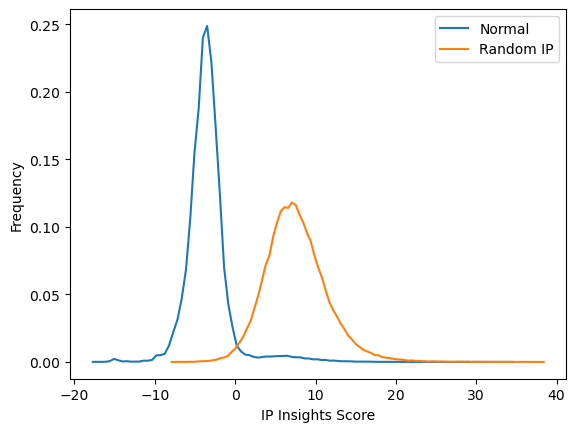

<Figure size 640x480 with 0 Axes>

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt

n, x = np.histogram(test_case_scores[:NUM_SAMPLES], bins=100, density=True)
plt.plot(x[1:], n)

n, x = np.histogram(test_case_scores[NUM_SAMPLES:], bins=100, density=True)
plt.plot(x[1:], n)

plt.legend(["Normal", "Random IP"])
plt.xlabel("IP Insights Score")
plt.ylabel("Frequency")

plt.figure()

### 4. Selecting a Good Threshold

As we see in the figure above, there is a clear separation between normal traffic and random traffic. 
We could select a threshold depending on the application.

- If we were working with low impact decisions, such as whether to ask for another factor or authentication during login, we could use a `threshold = 0.0`. This would result in catching more true-positives, at the cost of more false-positives. 

- If our decision system were more sensitive to false positives, we could choose a larger threshold, such as `threshold = 10.0`. That way if we were sending the flagged cases to manual investigation, we would have a higher confidence that the acitivty was suspicious. 

In [100]:
threshold = 0.0

flagged_cases = test_case[np.array(test_case_scores) > threshold]

num_flagged_cases = len(flagged_cases)
num_true_positives = len(flagged_cases[flagged_cases["label"] == 1])
num_false_positives = len(flagged_cases[flagged_cases["label"] == 0])
num_all_positives = len(test_case.loc[test_case["label"] == 1])

print(f"When threshold is set to: {threshold}")
print(f"Total of {num_flagged_cases} flagged cases")
print(f"Total of {num_true_positives} flagged cases are true positives")
print(f"True Positive Rate: {num_true_positives / float(num_flagged_cases)}")
print(f"Recall: {num_true_positives / float(num_all_positives)}")
print(f"Precision: {num_true_positives / float(num_flagged_cases)}")

When threshold is set to: 0.0
Total of 103000 flagged cases
Total of 98469 flagged cases are true positives
True Positive Rate: 0.9560097087378641
Recall: 0.98469
Precision: 0.9560097087378641


## Epilogue
----

In this notebook, we have showed how to configure the basic training, deployment, and usage of the Amazon SageMaker IP Insights algorithm. All SageMaker algorithms come with support for two additional services that make optimizing and using the algorithm that much easier: Automatic Model Tuning and Batch Transform service. 


### Amazon SageMaker Automatic Model Tuning
The results above were based on using the default hyperparameters of the SageMaker IP Insights algorithm. If we wanted to improve the model's performance even more, we can use [Amazon SageMaker Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) to automate the process of finding the hyperparameters. 

#### Validation Dataset
Previously, we separated our dataset into a training and test set to validate the performance of a single IP Insights model. However, when we do model tuning, we train many IP Insights models in parallel. If we were to use the same test dataset to select the best model, we bias our model selection such that we don't know if we selected the best model in general, or just the best model for that particular dateaset. 

Therefore, we need to separate our test set into a validation dataset and a test dataset. The validation dataset is used for model selection. Then once we pick the model with the best performance, we evaluate it the winner on a test set just as before. 

#### Validation Metrics
For SageMaker Automatic Model Tuning to work, we need an objective metric which determines the performance of the model we want to optimize. Because SageMaker IP Insights is an usupervised algorithm, we do not have a clearly defined metric for performance (such as percentage of fraudulent events discovered). 

We allow the user to provide a validation set of sample data (same format as training data bove) through the `validation` channel. We then fix the negative sampling strategy to use `random_negative_sampling_rate=1` and `shuffled_negative_sampling_rate=0` and generate a validation dataset by assigning corresponding labels to the real and simulated data. We then calculate the model's `descriminator_auc` metric. We do this by taking the model's predicted labels and the 'true' simulated labels and compute the Area Under ROC Curve (AUC) on the model's performance.

We set up the `HyperParameterTuner` to maximize the `discriminator_auc` on the validation dataset. We also need to set the search space for the hyperparameters. We give recommended ranges for the hyperparmaeters in the [Amazon SageMaker IP Insights (Hyperparameters)](https://docs.aws.amazon.com/sagemaker/latest/dg/ip-insights-hyperparameters.html) documentation. 


In [103]:
test_df["timestamp"].describe()

/tmp/ipykernel_5094/1189181443.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  test_df["timestamp"].describe()


count                  958825
unique                 252729
top       2018-11-11 09:45:07
freq                       16
first     2018-11-11 00:00:01
last      2018-11-14 00:00:00
Name: timestamp, dtype: object

The test set we constructed above spans 3 days. We reserve the first day as the validation set and the subsequent two days for the test set. 

In [104]:
time_partition = (
    datetime(2018, 11, 13, tzinfo=pytz.FixedOffset(0))
    if num_time_zones > 1
    else datetime(2018, 11, 13)
)

validation_df = test_df[test_df["timestamp"] < time_partition]
test_df = test_df[test_df["timestamp"] >= time_partition]

valid_data = validation_df.to_csv(index=False, header=False, columns=["user", "ip_address"])

We then upload the validation data to S3 and specify it as the validation channel. 

In [105]:
# Upload data to S3 key
validation_data_file = "valid.csv"
key = os.path.join(prefix, "validation", validation_data_file)
boto3.resource("s3").Bucket(bucket).Object(key).put(Body=valid_data)
s3_valid_data = f"s3://{bucket}/{key}"

print(f"Validation data has been uploaded to: {s3_valid_data}")

# Configure SageMaker IP Insights Input Channels
input_data = {"train": s3_train_data, "validation": s3_valid_data}

Validation data has been uploaded to: s3://aseansecaiml-25apr2023/sagemaker/ipinsights-tutorial/validation/valid.csv


In [ ]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter

# Configure HyperparameterTuner
ip_insights_tuner = HyperparameterTuner(
    estimator=ip_insights,  # previously-configured Estimator object
    objective_metric_name="validation:discriminator_auc",
    hyperparameter_ranges={"vector_dim": IntegerParameter(64, 1024)},
    max_jobs=4,
    max_parallel_jobs=2,
)

# Start hyperparameter tuning job
ip_insights_tuner.fit(input_data, include_cls_metadata=False)

INFO:sagemaker:Creating hyperparameter tuning job with name: ipinsights-230427-0926


..............................

In [109]:
# Wait for all the jobs to finish
ip_insights_tuner.wait()

# Visualize training job results
ip_insights_tuner.analytics().dataframe()

!


,vector_dim,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,677.0,ipinsights-230427-0926-004-2b5506b0,Completed,0.989283,2023-04-27 09:41:08+00:00,2023-04-27 09:51:02+00:00,594.0
1,332.0,ipinsights-230427-0926-003-f38d5fd8,Completed,0.990640,2023-04-27 09:41:06+00:00,2023-04-27 09:50:30+00:00,564.0
2,769.0,ipinsights-230427-0926-002-5e4a0797,Completed,0.988644,2023-04-27 09:27:54+00:00,2023-04-27 09:40:29+00:00,755.0
3,485.0,ipinsights-230427-0926-001-bc568f65,Completed,0.990173,2023-04-27 09:27:50+00:00,2023-04-27 09:40:00+00:00,730.0


In [110]:
# Deploy best model
tuned_predictor = ip_insights_tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=csv_serializer,
    deserializer=json_deserializer,
)


2023-04-27 09:50:32 Starting - Found matching resource for reuse
2023-04-27 09:50:32 Downloading - Downloading input data
2023-04-27 09:50:32 Training - Training image download completed. Training in progress.
2023-04-27 09:50:32 Uploading - Uploading generated training model
2023-04-27 09:50:32 Completed - Resource released due to keep alive period expiry

INFO:sagemaker:Creating model with name: ipinsights-2023-04-28-02-55-53-972


INFO:sagemaker:Creating endpoint-config with name ipinsights-230427-0926-003-f38d5fd8
INFO:sagemaker:Creating endpoint with name ipinsights-230427-0926-003-f38d5fd8


---------!

In [111]:
# Make a prediction against the SageMaker endpoint
tuned_predictor.predict(
    inference_data, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'dot_product': 4.1678667068481445},
  {'dot_product': -10.637112617492676},
  {'dot_product': 2.4053802490234375},
  {'dot_product': 2.9765799045562744},
  {'dot_product': 3.9288673400878906}]}

In [112]:
# Visualise the anomaly
test_case_scores_tuned = score_ip_insights(predictor, test_case)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


We should have the best performing model from the training job! Now we can determine thresholds and make predictions just like we did with the inference endpoint [above](#Inference).

### Batch Transform
Let's say we want to score all of the login events at the end of the day and aggregate flagged cases for investigators to look at in the morning. If we store the daily login events in S3, we can use IP Insights with [Amazon SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html) to run inference and store the IP Insights scores back in S3 for future analysis.

Below, we take the training job from before and evaluate it on the validation data we put in S3.

In [ ]:
transformer = ip_insights.transformer(instance_count=1, instance_type="ml.m4.xlarge")

transformer.transform(s3_valid_data, content_type="text/csv", split_type="Line")

INFO:sagemaker:Creating model with name: ipinsights-2023-04-28-03-38-42-694
INFO:sagemaker:Created S3 bucket: sagemaker-ap-southeast-1-817562650497
INFO:sagemaker:Creating transform job with name: ipinsights-2023-04-28-03-38-43-430


.........

In [142]:
#Read S3 Files
import boto3
import sys
from io import StringIO
import pandas as pd

# Initialize boto3 to use S3 resource
s3_resource = boto3.resource('s3')
def readFile(bucket, key):
    try:

        df = []   # Initializing empty list of dataframes

        # Get the object from the S3 Bucket
        s3_object = s3_resource.Object(
            bucket_name=bucket, 
            key=key
        )

        # Get the response from get_object()
        s3_response = s3_object.get()

        # Get the Body object from the S3 get_object() response
        s3_object_body = s3_response.get('Body')

        # Read the data in bytes format and convert it to string
        content_str = s3_object_body.read().decode()
        #print(content_str)
        df = pd.read_csv(StringIO(content_str), sep=",", header=None, names=['users', 'IP'])
        return df

    except s3_resource.meta.client.exceptions.NoSuchBucket as e:
        # S3 Bucket does not exist
        print('NO SUCH BUCKET')
        print(e)

    except s3_resource.meta.client.exceptions.NoSuchKey as e:
        # Object does not exist in the S3 Bucket
        print('NO SUCH KEY')
        print(e)

In [143]:
df = readFile(bucket, key)
df.head()

,users,IP
0,user_63,117.197.31.85
1,user_63,117.196.121.229
2,user_63,117.195.150.50
3,user_63,107.181.81.80
4,user_63,107.181.96.198


In [134]:
# Wait for Transform Job to finish
transformer.wait()

..............................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[04/28/2023 03:46:24 INFO 139744972494656] loaded entry point class algorithm.serve.server_config:config_api
[04/28/2023 03:46:24 INFO 139744972494656] loading entry points
[04/28/2023 03:46:24 INFO 139744972494656] Loaded iterator creator application/x-ndarray for content type ('application/x-ndarray', '1.0')
[04/28/2023 03:46:24 INFO 139744972494656] Loaded iterator creator text/csv for content type ('text/csv', '1.0')
[04/28/2023 03:46:24 INFO 139744972494656] loaded request iterator application/json
[04/28/2023 03:46:24 INFO 139744972494656] loaded request iterator application/jsonlines
[04/28/2023 03:46:24 INFO 139744972494656] loaded request iterator text/csv
[04/28/2023 03:46:24 INFO 139744972494656] loaded response encoder application/json
[04/28/2023 03:

In [135]:
print(f"Batch Transform output is at: {transformer.output_path}")

Batch Transform output is at: s3://sagemaker-ap-southeast-1-817562650497/ipinsights-2023-04-28-03-38-43-430


In [149]:
#List all the files in S3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket("sagemaker-ap-southeast-1-817562650497")

for my_bucket_object in my_bucket.objects.all():
    print(f"{my_bucket_object.key}\n")
    key = my_bucket_object.key
    df = readFile("sagemaker-ap-southeast-1-817562650497",key)

ipinsights-2023-04-28-03-38-43-430/valid.csv.out



In [150]:
df.head()

,users,IP
0,"{""dot_product"":-0.190504431724548}",NaN
1,"{""dot_product"":1.138126730918884}",NaN
2,"{""dot_product"":0.56033170223236}",NaN
3,"{""dot_product"":3.613718271255493}",NaN
4,"{""dot_product"":2.987053155899048}",NaN


### Stop and Delete the Endpoint
If you are done with this model, then we should delete the endpoint before we close the notebook. Or else you will continue to pay for the endpoint while it is running. 

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [ ]:
tuned_predictor.delete_model()
tuned_predictor.delete_endpoint()

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()

In [ ]:
transformer.delete_model()